<a href="https://colab.research.google.com/github/LaidProgrammer/NN_check_for_printed_attack/blob/master/Printed_attack_test_resnet18_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# при выполнении следующего кода откроется дополнительная страница, на которой вас попросят
# авторизироваться в Google Drive, выдать разрешение на подключение к Colab и выдадут код
# для подключения, который нужно скопировать в появившееся ниже поле
from google.colab import drive
# google drive станет доступен по пути /content/gdrive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# просканируем файловую систему на предмет файлов с расширением JPEG
from pathlib import Path
import numpy as np

image_train_files = list(Path('./gdrive/My Drive/Colab Notebooks/Printed_attack/train').glob('**/*.png'))
print(f"Found {len(image_train_files)} image train files.")

# для каждого файла нам нужно из названия папки, в которой он лежит, извлечь имя метки класса:
image_train_labels = []
for file in image_train_files:
    label = file.parent.name
    image_train_labels.append(label)
print(f"Found {len(image_train_labels)} image train labels, {len(np.unique(image_train_labels))} unique classes.")

image_test_files = list(Path('./gdrive/My Drive/Colab Notebooks/Printed_attack/valid').glob('**/*.png'));
print(f"Found {len(image_test_files)} image valid-test files.")

# для каждого файла нам нужно из названия папки, в которой он лежит, извлечь имя метки класса:
image_test_labels = []
for file in image_test_files:
    label = file.parent.name
    image_test_labels.append(label)
print(f"Found {len(image_test_labels)} image valid-test labels, {len(np.unique(image_test_labels))} unique classes.")

Found 8334 image train files.
Found 8334 image train labels, 2 unique classes.
Found 1015 image valid-test files.
Found 1015 image valid-test labels, 2 unique classes.


In [0]:
# посмотрим на несколько случайных изображений из датасета:
from PIL import Image

random_image_file = np.random.choice(image_train_files)
image = Image.open(random_image_file)
print(random_image_file)
# просто вызов загруженного изображения в colab'е отобразит его
image

In [0]:
# нужно разделить список файлов на три выборки: тренировочную, валидационную и тестовую
from sklearn.model_selection import train_test_split

train_val_files, test_files, train_val_labels, test_labels = train_test_split(image_files, image_labels, stratify=image_labels, test_size=0.3)
train_files, val_files = train_test_split(train_val_files, stratify=train_val_labels, test_size=0.15)
print(f"Splitted into: {len(train_files)} train files; {len(val_files)} validation files; {len(test_files)} test files.")

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Compose, ToTensor, Normalize
from fastprogress import progress_bar

transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# пишем кастомный датасет, который загрузит наши изображения в память
# и будет превращать их в тензоры и отдавать загрузчику
class CustomDataset(Dataset):
    # конструктору класса нужно знать пути к файлам, которые загружать, 
    # режим (обучение/тест) и к какому размеру масштабировать изображения
    def __init__(self, files, mode, rescale_size):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.rescale_size = rescale_size
        self.images = []
        # LabelEncoder нужен для преобразования меток классов в id и обратно
        self.label_encoder = LabelEncoder()
        
        # загрузка изображений в память
        print(f"Loading {self.mode} files")
        for file in progress_bar(self.files):
            image = Image.open(file)
            if image.mode != 'RGB':
                image = image.convert(mode='RGB')
            image = image.resize((self.rescale_size, self.rescale_size))
            self.images.append(image)

        if self.mode != 'test':
            # выделяем метку из названия папки
            self.labels = [file.parent.name for file in self.files]
            self.label_encoder.fit(self.labels)


    def __len__(self):
        return len(self.files)
  
  
    def __getitem__(self, index):
        x = self.images[index]
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [0]:
train_dataset = CustomDataset(files=image_train_files, mode='train', rescale_size=196)
val_dataset = CustomDataset(files=image_test_files, mode='val', rescale_size=196)
test_dataset = CustomDataset(files=image_test_files, mode='test', rescale_size=196)

Loading train files


In [0]:
class ShallowCNN(nn.Module):
    
    def __init__(self, n_classes):
        super().__init__()
        # размерность входа: (3x256x256)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # размерность после слоя: (16x127x127)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=50, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # размерность после слоя: (16x62x62)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=50, out_channels=80, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # размерность после слоя: (32x30x30)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=80, out_channels=100, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # размерность после слоя: (64x14x14)
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=100, out_channels=120, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # размерность после слоя: (96x6x6)
        # полносвязный классификатор должен знать, вектор какой размерности будет на выходе сверточной части, 
        # поэтому необходимо следить за размерностями тензоров
        self.linear1 = nn.Linear(120 * 4 * 4, 200)
        self.linear2 = nn.Linear(200, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # преобразование в одномерный вектор
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [0]:
from torchsummary import summary

summary(ShallowCNN(n_classes=120).cuda(), (3, 196, 196))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 194, 194]             448
              ReLU-2         [-1, 16, 194, 194]               0
         MaxPool2d-3           [-1, 16, 97, 97]               0
            Conv2d-4           [-1, 50, 95, 95]           7,250
              ReLU-5           [-1, 50, 95, 95]               0
         MaxPool2d-6           [-1, 50, 47, 47]               0
            Conv2d-7           [-1, 80, 45, 45]          36,080
              ReLU-8           [-1, 80, 45, 45]               0
         MaxPool2d-9           [-1, 80, 22, 22]               0
           Conv2d-10          [-1, 100, 20, 20]          72,100
             ReLU-11          [-1, 100, 20, 20]               0
        MaxPool2d-12          [-1, 100, 10, 10]               0
           Conv2d-13            [-1, 120, 8, 8]         108,120
             ReLU-14            [-1, 12

In [0]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

loss_function = nn.CrossEntropyLoss()

In [0]:
from fastprogress import master_bar, progress_bar


def train_net(net, train_loader, val_loader, loss_function, num_epochs, lr):
    
    # для построения графиков
    history = {
        'loss': [],
        'acc': [],
        'val_loss': [],
        'val_acc': []
    }
    # для логгирования
    log_template = "Epoch {ep:03d}: train_loss={t_loss:0.4f} val_loss={v_loss:0.4f} train_acc={t_acc:0.4f} val_acc ={v_acc:0.4f}"
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    print("Training")
    epoch_bar = master_bar(range(num_epochs), order=['pb1', 'pb2', 'text'])
    for epoch in epoch_bar:
        # статистики во время обучения
        running_loss = 0.0
        running_corrects = 0
        processed_data = 0
        
        net.train()
        for images, labels in progress_bar(train_loader, total=len(train_loader), parent=epoch_bar):
            images = images.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            
            outputs = net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # статистики во время обучения
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += images.size(0)
            
            epoch_bar.child.comment = f"loss={(running_loss / processed_data):0.4f} acc={(running_corrects.cpu().numpy() / processed_data):0.4f}"
        
        # статистики во время обучения
        train_loss = running_loss / processed_data
        train_acc = running_corrects.cpu().numpy() / processed_data
        
        running_loss = 0.0
        running_corrects = 0
        processed_data = 0
        
        net.eval()
        for images, labels in progress_bar(val_loader, total=len(val_loader), parent=epoch_bar):
            images = images.cuda()
            labels = labels.cuda()
            
            outputs = net(images)
            loss = loss_function(outputs, labels)
            
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += images.size(0)
            
            epoch_bar.child.comment = f"val_loss={(running_loss / processed_data):0.4f} val_acc={(running_corrects.cpu().numpy() / processed_data):0.4f}"
        
        val_loss = running_loss / processed_data
        val_acc = running_corrects.cpu().numpy() / processed_data
        # сохраняем значения текущей эпохи
        history['loss'].append(train_loss)
        history['acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        epoch_bar.comment = f"loss={train_loss:0.4f} acc={train_acc:0.4f} val_loss={val_loss:0.4f} val_acc={val_acc:0.4f}"
        epoch_bar.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    
    return history

In [0]:
def predict(net, test_loader):
    probs = []
    net.eval()
    print("Predicting")
    for batch in progress_bar(test_loader, total=len(test_loader)):
        if isinstance(batch, list):
            images, _ = batch
        else:
            images = batch
        images = images.cuda()
        out = net(images)
        out = nn.Softmax(dim=1)(out)
        probs.append(out.cpu().detach().numpy())

    probs = np.concatenate(probs)
    return probs

In [0]:
from torch import nn

class Linear(nn.Module):
    
    def __init__(self, n_classes):
        super().__init__()
        self.ln1 = nn.Linear(n_classes, 2)

    def forward(self, x):
        x = self.ln1(x)
        #x = self.ln6(x)
        # преобразование в одномерный вектор
        return x

In [16]:
from torchvision import models

mylinnet = Linear(512)
mynet = models.resnet18(pretrained=True)
mynet.fc = mylinnet
mynet = mynet.cuda()
history = train_net(mynet, train_loader, val_loader, loss_function, num_epochs=7, lr=1e-5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 40.8MB/s]


Training


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


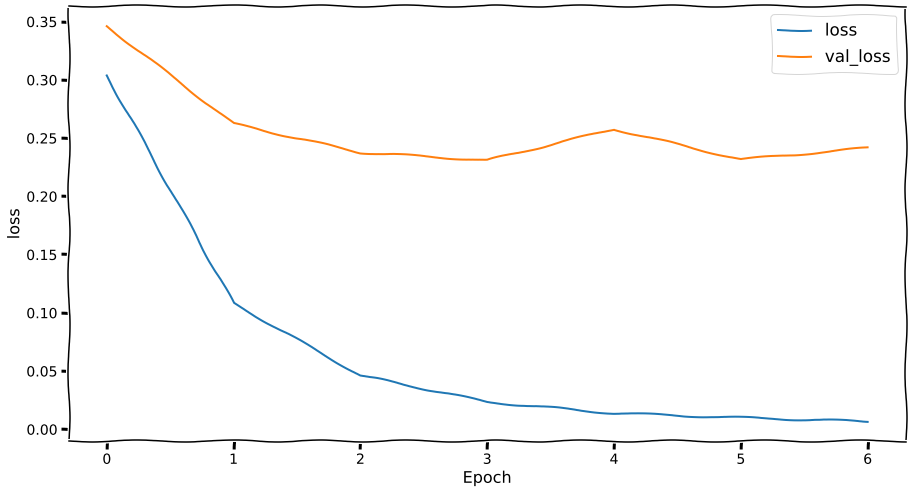

In [18]:
from matplotlib import pyplot as plt
with plt.xkcd():
    fig = plt.figure(figsize=(15, 8))
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel("Epoch", fontsize='16')
    plt.ylabel("loss", fontsize='16')
    plt.legend(fontsize='large')
    plt.show()

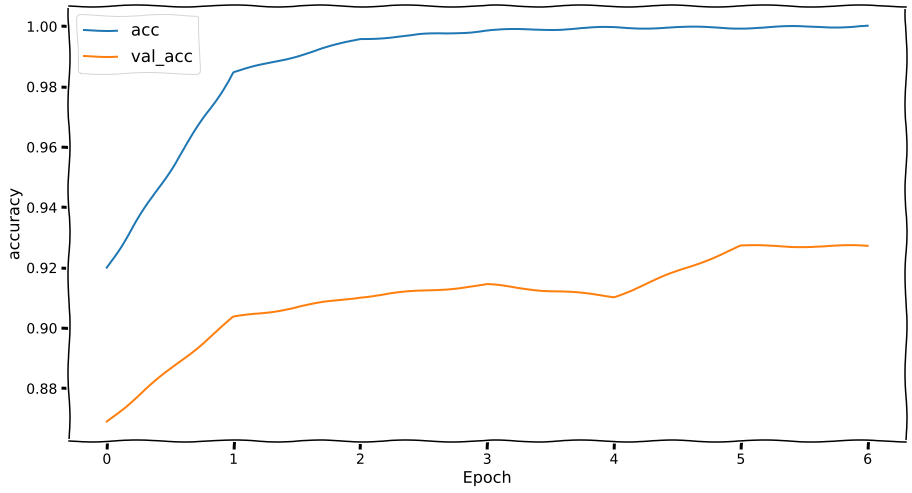

In [19]:
with plt.xkcd():
    fig = plt.figure(figsize=(15, 8))
    plt.plot(history['acc'], label='acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.xlabel("Epoch", fontsize='16')
    plt.ylabel("accuracy", fontsize='16')
    plt.legend(fontsize='large')
    plt.show()

In [21]:
from sklearn.metrics import accuracy_score, classification_report

train_eval_loader = DataLoader(train_dataset, batch_size=64)
probs_train = predict(mynet, train_eval_loader)
pred_train = np.argmax(probs_train, axis=1)
true_train = train_dataset.label_encoder.transform(train_dataset.labels)

print(f"Доля правильных ответов (accuracy) на трейне: {accuracy_score(true_train, pred_train)*100}%")
print(classification_report(true_train, pred_train, target_names=train_dataset.label_encoder.classes_))

Predicting


Доля правильных ответов (accuracy) на трейне: 100.0%
              precision    recall  f1-score   support

        real       1.00      1.00      1.00      1223
       spoof       1.00      1.00      1.00      7111

    accuracy                           1.00      8334
   macro avg       1.00      1.00      1.00      8334
weighted avg       1.00      1.00      1.00      8334



In [23]:
probs_val = predict(mynet, val_loader)
pred_val = np.argmax(probs_val, axis=1)
true_val = train_dataset.label_encoder.transform(val_dataset.labels)

print(f"Доля правильных ответов (accuracy) на валидации: {accuracy_score(true_val, pred_val)*100}%")
print(classification_report(true_val, pred_val, target_names=train_dataset.label_encoder.classes_))

Predicting


Доля правильных ответов (accuracy) на валидации: 92.70935960591133%
              precision    recall  f1-score   support

        real       0.95      0.85      0.90       373
       spoof       0.92      0.97      0.94       642

    accuracy                           0.93      1015
   macro avg       0.93      0.91      0.92      1015
weighted avg       0.93      0.93      0.93      1015



In [25]:
probs_test = predict(mynet, test_loader)
pred_test = np.argmax(probs_test, axis=1)
true_test = train_dataset.label_encoder.transform([file.parent.name for file in test_dataset.files])

print(f"Доля правильных ответов (accuracy) на тесте: {accuracy_score(true_test, pred_test)*100}%")
print(classification_report(true_test, pred_test, target_names=train_dataset.label_encoder.classes_))

Predicting


Доля правильных ответов (accuracy) на тесте: 92.70935960591133%
              precision    recall  f1-score   support

        real       0.95      0.85      0.90       373
       spoof       0.92      0.97      0.94       642

    accuracy                           0.93      1015
   macro avg       0.93      0.91      0.92      1015
weighted avg       0.93      0.93      0.93      1015



In [0]:
from pathlib import Path
from PIL import Image
import random

image_view_files = list(Path('./gdrive/My Drive/Colab Notebooks/Printed_attack/train/spoof').glob('*.png'))

images = list()
images.append(random.choice(image_view_files))

In [42]:
import numpy as np

test_dataset = CustomDataset(files=images, mode='test', rescale_size=196)
test_loader = DataLoader(test_dataset, batch_size=128, num_workers=2, pin_memory=True)
probs_test = predict(mynet, test_loader)
print(probs_test)
pred_test = np.argmax(probs_test, axis=1)
print(pred_test)
if (pred_test[0] == 1):
   print("Spoof")
else:
   print("Real")

Loading test files


Predicting


[[2.6864494e-04 9.9973136e-01]]
[1]
Spoof
